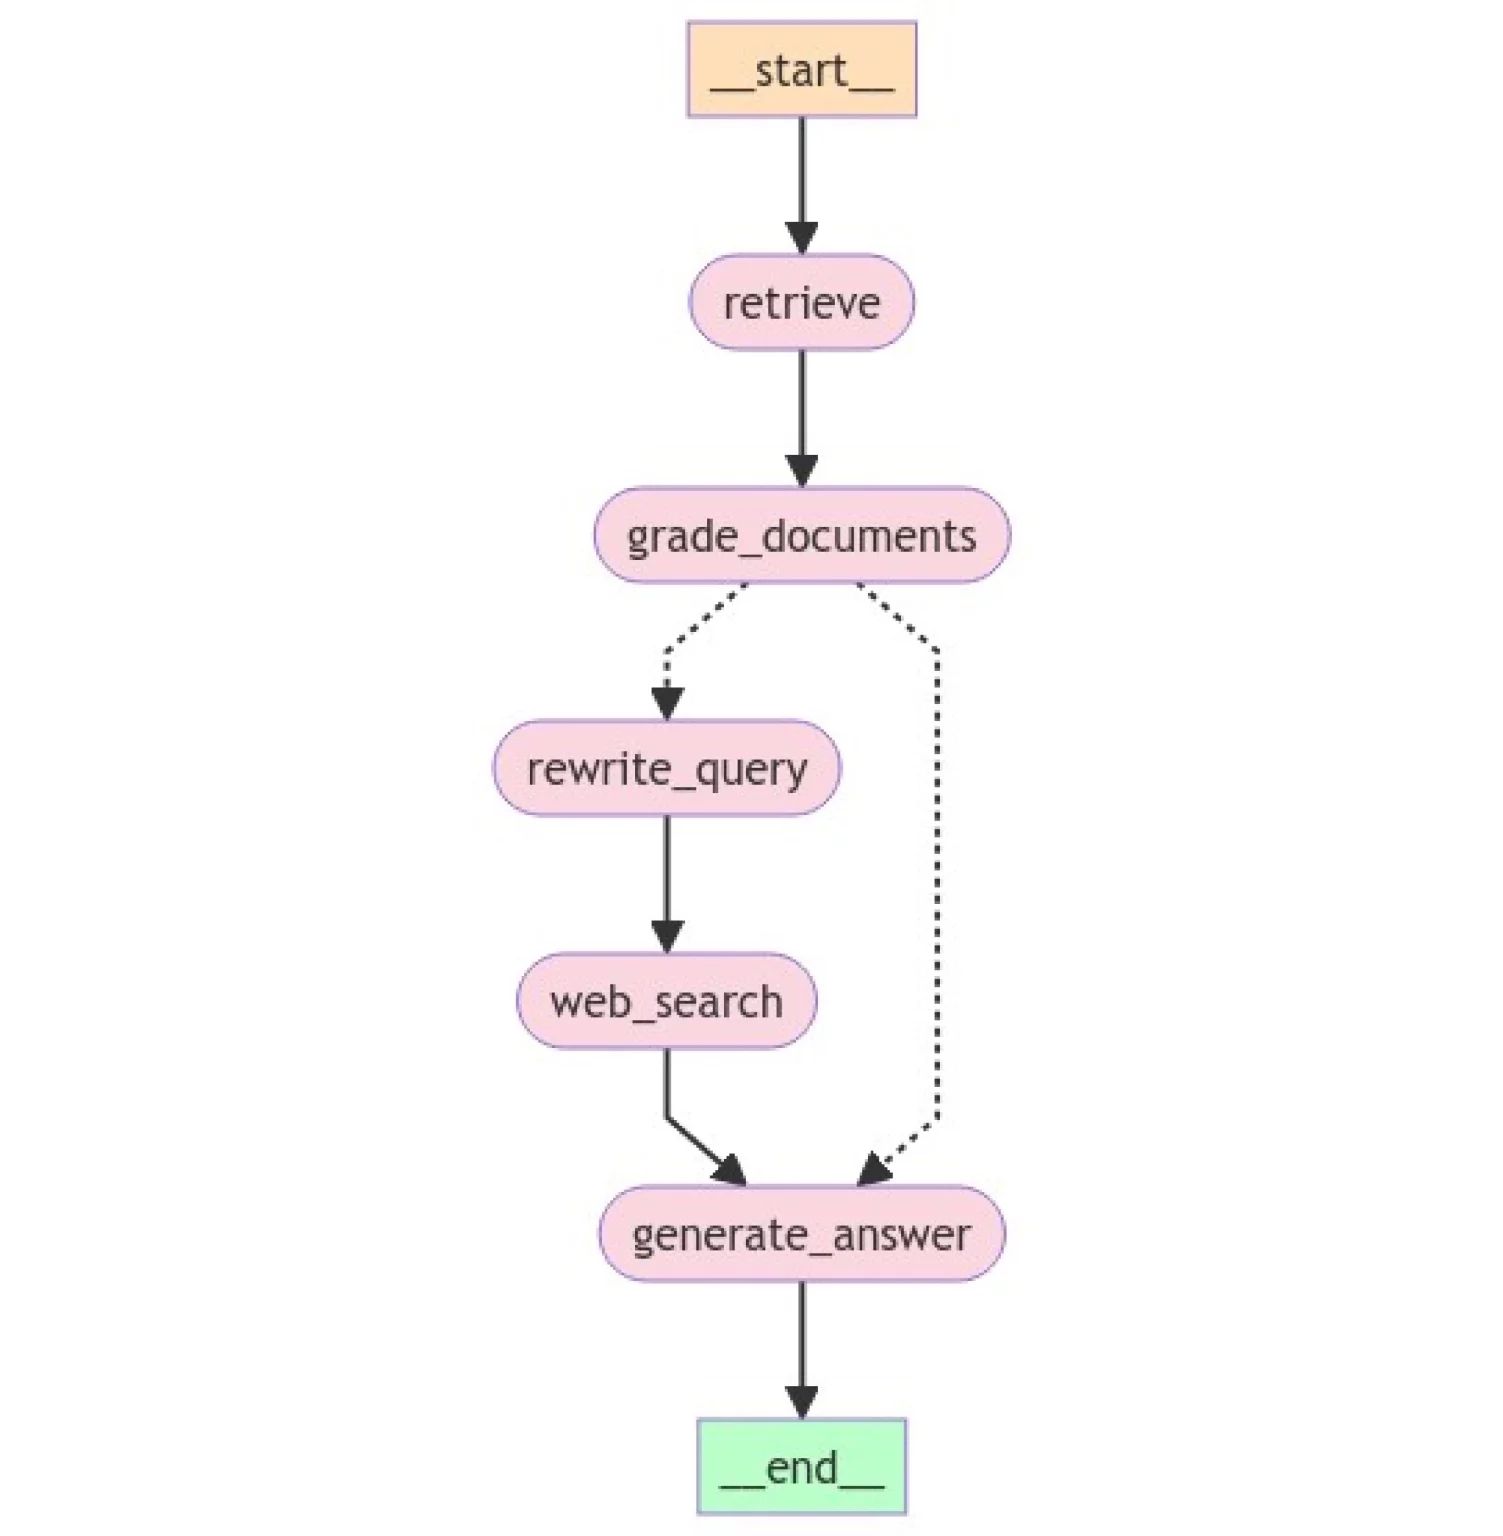

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages
from pydantic import BaseModel

load_dotenv(override=True)

True

In [ ]:
import os
from google import genai
from langchain_google_genai import GoogleGenerativeAIEmbeddings



GEMINI_API_KEY=os.getenv("GEMINI_API_KEY")

client = genai.Client(api_key=GEMINI_API_KEY)

gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")


## Get the Wikipedia Data



In [ ]:

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
)

In [6]:
import gzip
import json
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

wikipedia_filepath = r'C:\development\genai_trng\ps2\data\simplewiki-2020-11-01.jsonl.gz'
docs = []
with gzip.open(wikipedia_filepath, 'rt', encoding='utf8') as fIn:
    for line in fIn:
        data = json.loads(line.strip())
        #Add documents
        docs.append({
                        'metadata': {
                                        'title': data.get('title'),
                                        'article_id': data.get('id')
                        },
                        'data': ' '.join(data.get('paragraphs')[0:3]) 
        # restrict data to first 3 paragraphs to run later modules faster
        })
# We subset our data to use a subset of wikipedia documents to run things faster
docs = [doc for doc in docs for x in ['india']
              if x in doc['data'].lower().split()]
# Create docs
docs = [Document(page_content=doc['data'],
                 metadata=doc['metadata']) for doc in docs]
# Chunk docs
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)
chunked_docs[:3]

[Document(metadata={'title': 'Basil', 'article_id': '73985'}, page_content='Basil ("Ocimum basilicum") ( or ) is a plant of the Family Lamiaceae. It is also known as Sweet Basil or Tulsi. It is a tender low-growing herb that is grown as a perennial in warm, tropical climates. Basil is originally native to India and other tropical regions of Asia. It has been cultivated there for more than 5,000 years. It is prominently featured in many cuisines throughout the world. Some of them are Italian, Thai, Vietnamese and Laotian cuisines. It grows to between 30–60\xa0cm tall. It has light green, silky leaves 3–5\xa0cm long and 1–3\xa0cm broad. The leaves are opposite each other. The flowers are quite big. They are white in color and arranged as a spike. The plant tastes somewhat like anise, with a strong, pungent, sweet smell. Basil is very sensitive to cold. It is best grown in hot, dry conditions. While most common varieties are treated as annuals, some are perennial, including African Blue a

## Create a Vector DB and Persist on the Disk

In [ ]:
# from langchain_huggingface import HuggingFaceEmbeddings

# local_embeddings = HuggingFaceEmbeddings(
#     model_name="sentence-transformers/all-MiniLM-L6-v2"
# )

In [18]:
from langchain_chroma import Chroma
# create vector DB of docs and embeddings
chroma_db = Chroma.from_documents(documents=chunked_docs,
                                  collection_name='rag_wikipedia_db',
                                  embedding=gemini_embeddings,
# need to set the distance function to cosine else it uses Euclidean by default
# check https://docs.trychroma.com/guides#changing-the-distance-function
                                  collection_metadata={"hnsw:space": "cosine"},
                                  persist_directory="./wikipedia_db_v2")

GoogleGenerativeAIError: Error embedding content: 404 models/gemini-embedding-003 is not found for API version v1beta, or is not supported for embedContent. Call ListModels to see the list of available models and their supported methods.

## Setup a Vector Database Retriever

In [15]:
similarity_threshold_retriever = chroma_db.as_retriever(search_type="similarity_score_threshold",
                       search_kwargs={"k": 3,                                                                       
                       "score_threshold": 0.3})
# We can then test if our retriever is working on some sample queries.
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(id='2913ecae-f51a-4697-8391-1cf449924326', metadata={'article_id': '391', 'title': 'India'}, page_content='India is a country in Asia. It has an area of . It is at the center of South Asia. India has more than 1.2 billion (1,210,000,000) people, which is the second largest population in the world. It is the seventh largest country in the world by area and the largest country in South Asia. It is also the most populous democracy in the world. India has seven neighbours: Pakistan in the north-west, China and Nepal in the north, Bhutan and Bangladesh in the north-east, Myanmar in the east and Sri Lanka, an island, in the south. The capital of India is New Delhi. India is a peninsula, bound by the Indian Ocean in the south, the Arabian Sea on the west and Bay of Bengal in the east. The coastline of India is of about long. India has the third largest military force in the world and is also a nuclear weapon state.'),
 Document(id='7bd07387-fa1e-4963-bd7e-a02c6adaaeef', metadata={'a

In [14]:
query = "what is langgraph?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(id='697aa6b7-2b54-4958-8f21-7f1c02d15097', metadata={'article_id': '523820', 'title': 'Tedim language'}, page_content='Tedim language is a language of India and Burma. It is a Kukish language.'),
 Document(id='2c0574c9-0cad-4a44-a546-832ba9c5129a', metadata={'article_id': '774543', 'title': 'Indology'}, page_content='Indology or Indian studies is the academic study of the history and cultures, languages, and literature of India and other Asian studies. There are two types of Indology, "Classical Indology" from "Modern Indology". Classical is about ancient India and Modern is about current-day India and its politics.'),
 Document(id='73b47786-1a47-4682-bb92-3cf115ead312', metadata={'article_id': '21553', 'title': 'Tamil language'}, page_content='Tamil is a Dravidian language. It is spoken in the Tamil Nadu and Puducherry states of India and parts of Sri Lanka. Many people in Singapore and Malaysia also speak it. Many people speaking Tamil live in various places around the worl

## Create a Query Retrieval Grader